# Проект: классификация

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing  import MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
df.isna().sum().sort_values(ascending=False)

balance      25
age           0
day           0
poutcome      0
previous      0
pdays         0
campaign      0
duration      0
month         0
contact       0
job           0
loan          0
housing       0
default       0
education     0
marital       0
deposit       0
dtype: int64

### Задание 2

In [5]:
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [6]:
df['balance'] = df['balance'].apply(lambda x: str(x).replace('$', '').replace(' ', '').replace(',', '.'))

In [7]:
df['balance'] = df['balance'].astype('float')

In [8]:
round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [9]:
df.loc[(df['balance'].isna()==True), 'balance'] = df['balance'].median()

In [10]:
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [11]:
df.loc[(df['job']=='unknown'), 'job'] = df['job'].mode()[0]

In [12]:
df.loc[(df['education']=='unknown'), 'education'] = df['education'].mode()[0]

In [13]:
print(df['job'].value_counts(ascending=False).index[0], ',', df['education'].value_counts(ascending=False).index[0])

management , secondary


In [14]:
df[(df['job'] == 'management') & (df['education'] == 'secondary')]['balance'].mean().round(3)

1598.883

### Задание 6

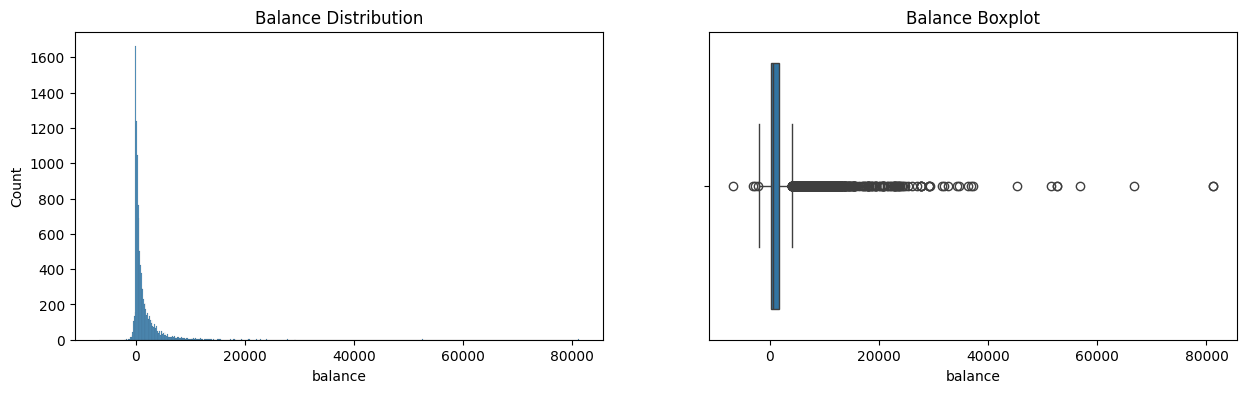

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Balance Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Balance Boxplot');

In [16]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    left_bound = quartile_1 - 1.5 * iqr
    right_bound = quartile_3 + 1.5 * iqr
    outliers = data[(x < left_bound) | (x > right_bound)]
    cleaned = data[(x >= left_bound) & (x <= right_bound)]
    return cleaned, left_bound, right_bound

In [17]:
df_new, low, high = outliers_iqr(df, 'balance')

In [18]:
print('low: {}, high: {}'.format(low, high))
df_new['balance'].count()

low: -2241.0, high: 4063.0


10105

## Часть 2:  Разведывательный анализ

### Задание 1

In [19]:
px.bar(df_new['deposit'].value_counts(), 
       x=df_new['deposit'].value_counts().index, 
       y=df_new['deposit'].value_counts().values,
       labels={'y': 'count', 'x': 'deposit'},
       text_auto=True,
       title='Расределение целевой переменной')

**Вывод:** отказавшихся от депозита больше, чем согласившихся. Но в целом распределение целевой переменной сбалансированное.

### Задания 2 и 3

In [20]:
df_new.describe(include=[np.number])

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Выводы:  
- *возраст:* минимальное значение - 18 лет, максимальное - 95. Среднее - 41 год. 75 квартиль - 48 лет, то есть на оставшиеся 25% приходится разброс в 47 лет;
- большой разброс в данных по *балансу*, от отрицательного остатка, до до большого максимального значения. Наблюдается большое значение стандартного отклонения;
- *Показатель продолжительности контакта:* 75 квартиль со значение 490, оставшаяся доля на достаточно большой диапазон данных до максимального зачения 3881. Наблюдается большое значение стандартного отклонения. Возможно есть выбросы;
- Показатель *контакты в текущей кампании:* максимальное значение сильно выбивается из данных. При этом среднняя и стандартное отклонение близки между собой, возможно нормальное распределение. 75 квартиль со значением 3 при максимальноем значениее 43;
- Показатель *контакты в предыдщущей кампании:* максимальное значение сильно выбивается из данных. При этом среднняя и стандартное отклонение близки между собой, возможно нормальное распределение. 75 квартиль со значением 3 при максимальноем значениее 43;

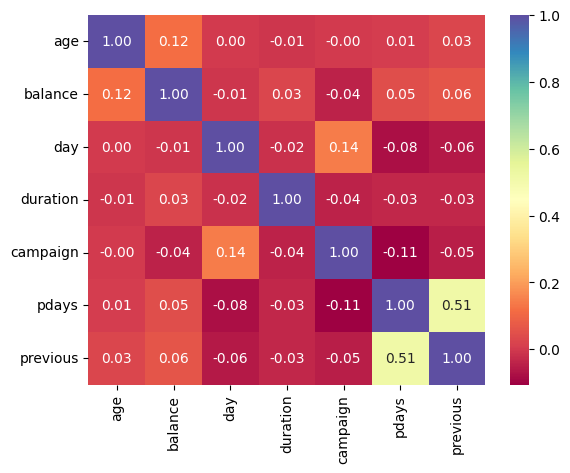

In [21]:
sns.heatmap(df_new.corr(numeric_only=True), annot=True, fmt='.2f', cmap='Spectral');

Мультиколлинеарность между признаками не наблюдается.

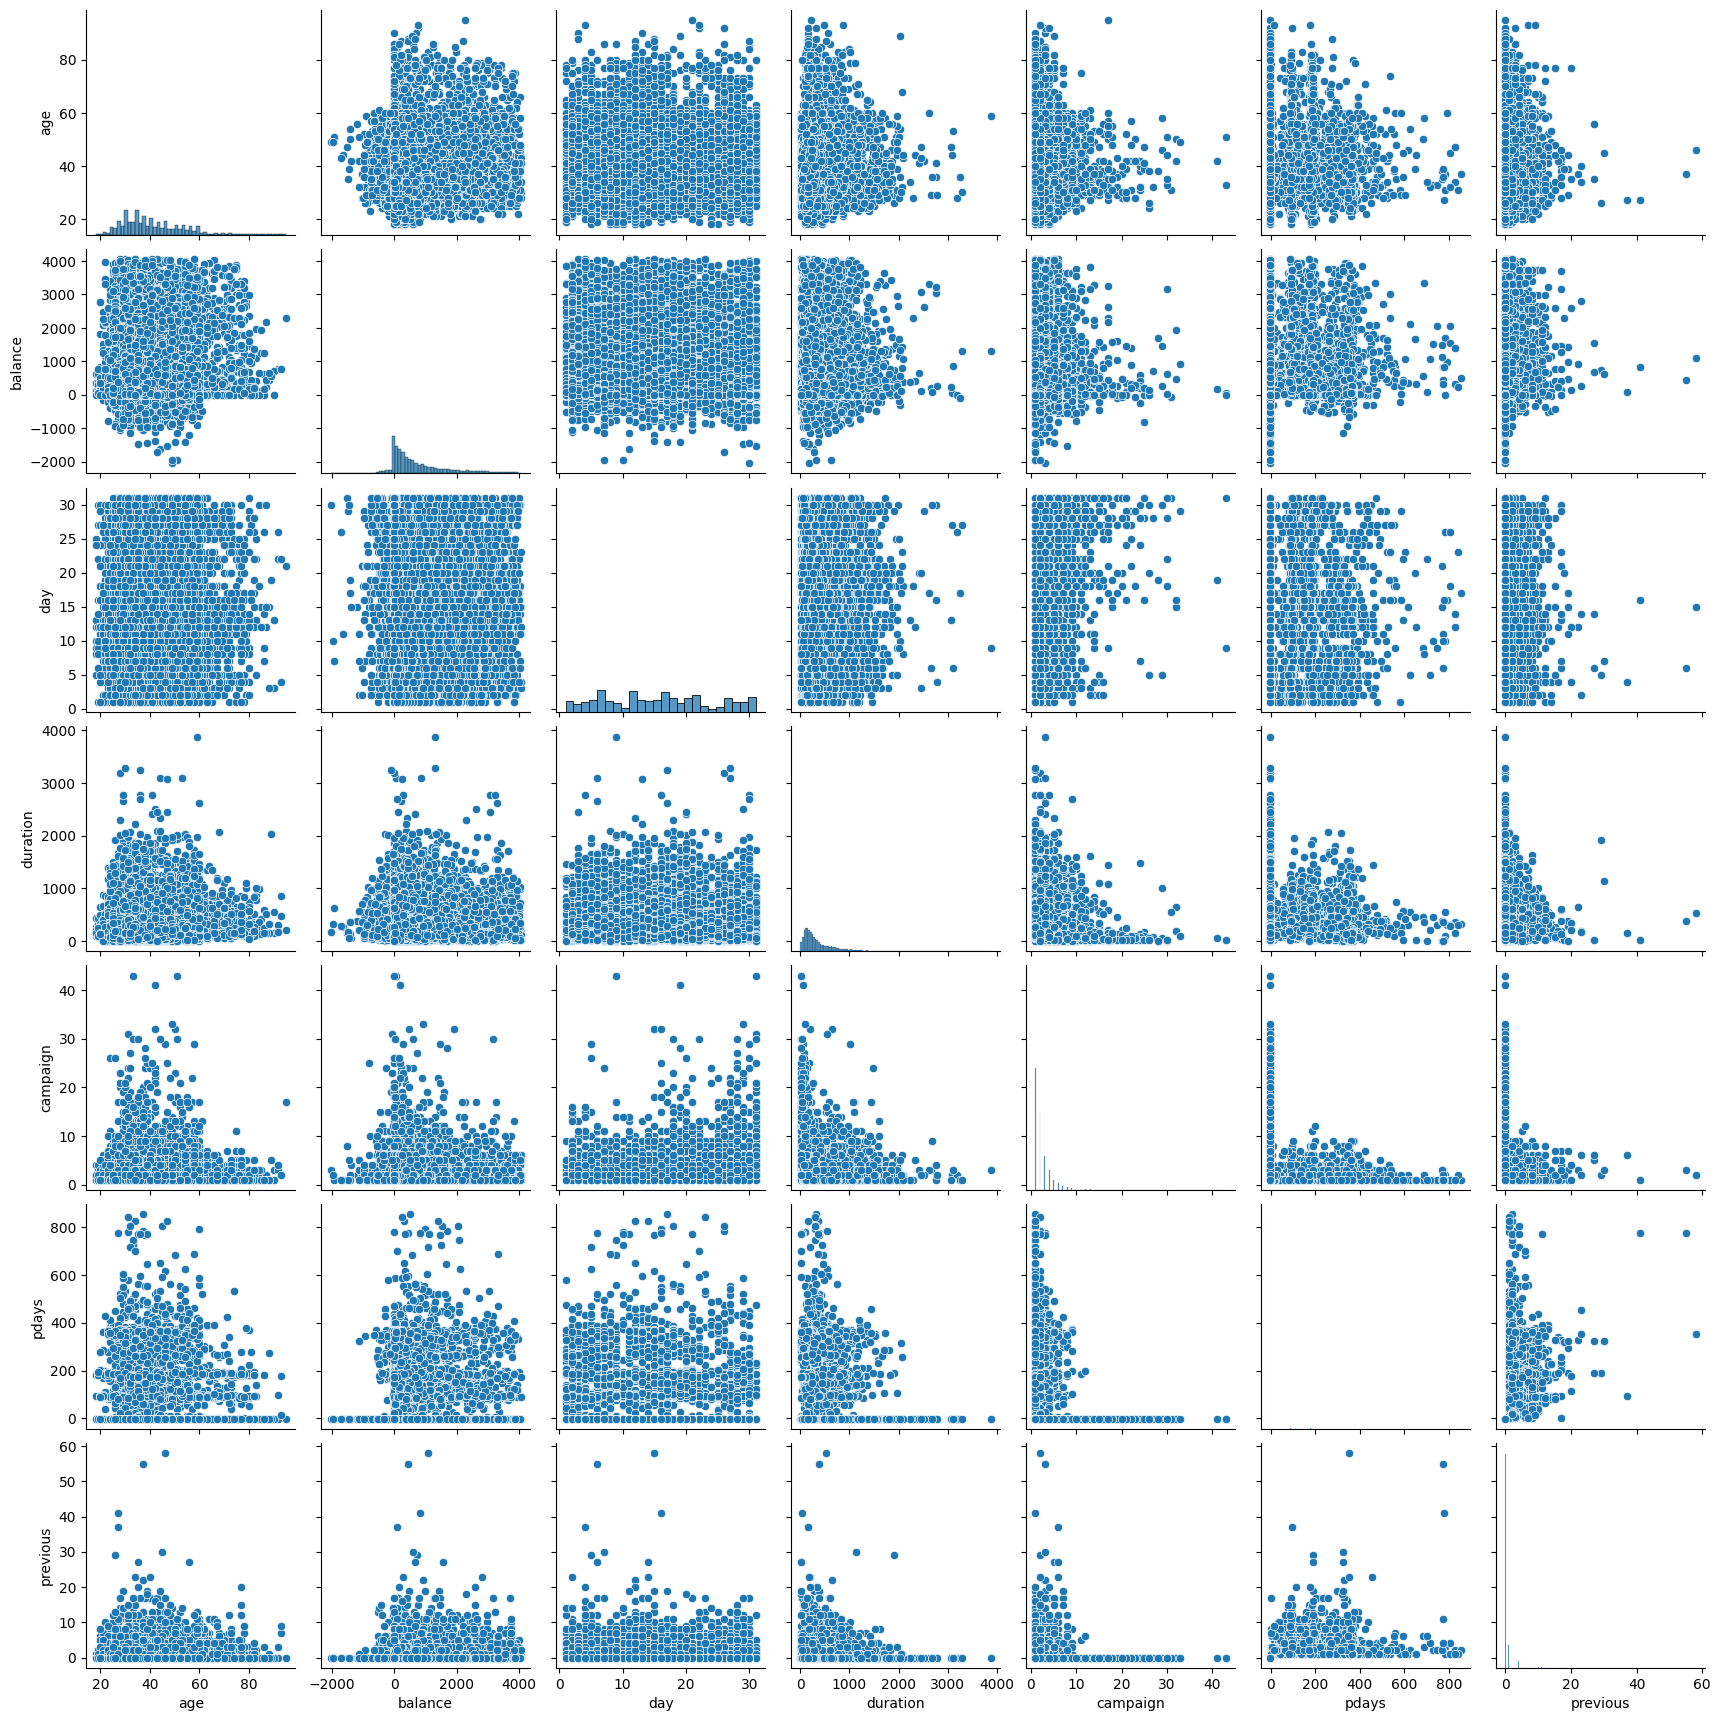

In [22]:
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
sns.pairplot(df_new[num_cols]);

Ни один признак не распределен нормально. Каких-либо зависимостей между признаками не наблюдается.

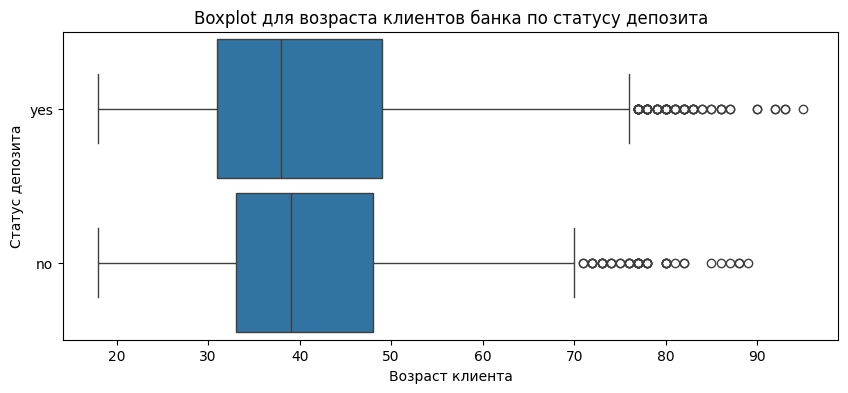

In [23]:
# строим график для возраста
fig = plt.figure(figsize=(10, 4))
boxplot = sns.boxplot(data=df_new, x='age', y='deposit', orient='h', width=0.9)
boxplot.set_title('Boxplot для возраста клиентов банка по статусу депозита', fontsize=12)
boxplot.set_xlabel('Возраст клиента')
boxplot.set_ylabel('Статус депозита');

**Вывод:** медианы возраста для тех, кто за деопозит и против мерно на одинаковом уровне. Ящик согласных на депозит более шире, то есть более молодые склонны к оформлению депозита. На графике прослеживается влияние возраста на принятие решения. Необходимо будет проверить на гипотезе.

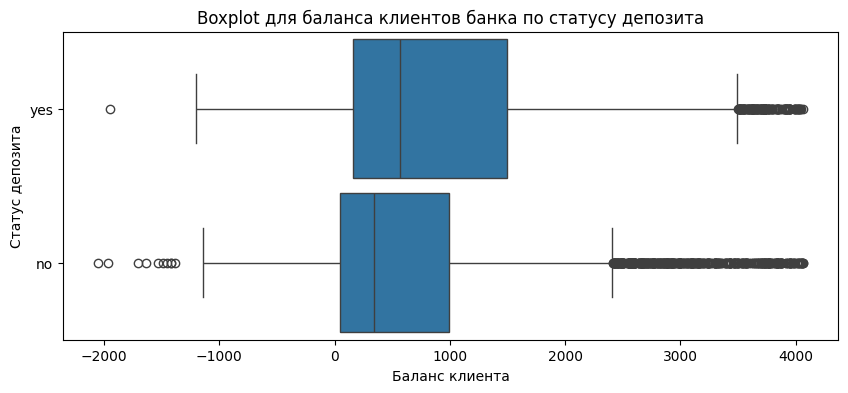

In [24]:
# строим график для баланса
fig = plt.figure(figsize=(10, 4))
boxplot = sns.boxplot(data=df_new, x='balance', y='deposit', orient='h', width=0.9)
boxplot.set_title('Boxplot для баланса клиентов банка по статусу депозита', fontsize=12)
boxplot.set_xlabel('Баланс клиента')
boxplot.set_ylabel('Статус депозита');

**Вывод:** на графике четко видно, что чем выше баланс у клиента, тем охотнее он открывает депозит.

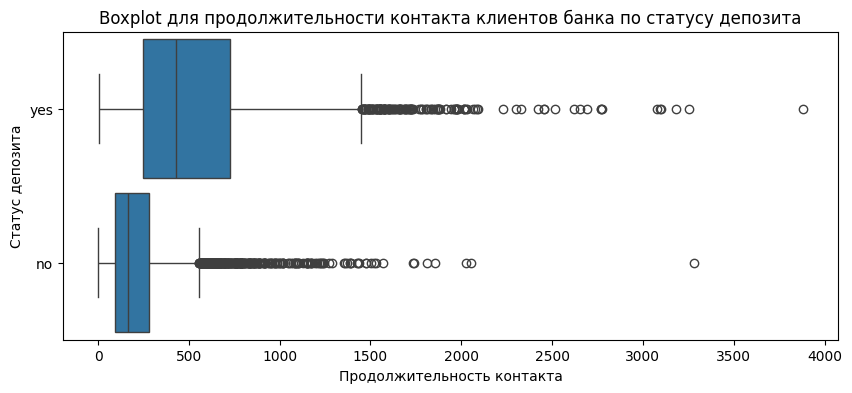

In [25]:
# строим график для баланса
fig = plt.figure(figsize=(10, 4))
boxplot = sns.boxplot(data=df_new, x='duration', y='deposit', orient='h', width=0.9)
boxplot.set_title('Boxplot для продолжительности контакта клиентов банка по статусу депозита', fontsize=12)
boxplot.set_xlabel('Продолжительность контакта')
boxplot.set_ylabel('Статус депозита');

**Вывод:** на графике четко видно, что чем продолжительнее был контакт с клиентом, тем охотнее он открывает депозит.

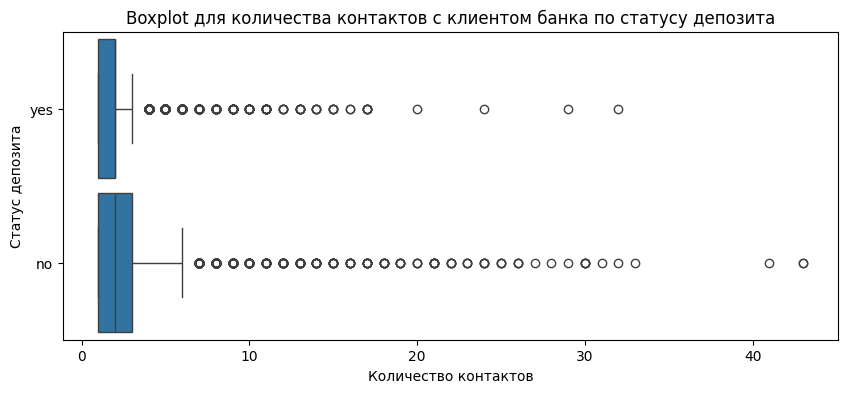

In [26]:
# строим график для количество контактов в текущую кампанию
fig = plt.figure(figsize=(10, 4))
boxplot = sns.boxplot(data=df_new, x='campaign', y='deposit', orient='h', width=0.9)
boxplot.set_title('Boxplot для количества контактов с клиентом банка по статусу депозита', fontsize=12)
boxplot.set_xlabel('Количество контактов')
boxplot.set_ylabel('Статус депозита');

**Вывод:** на графике видно, что чем меньше было контактов с клиентом, тем охотнее он открывает депозит.

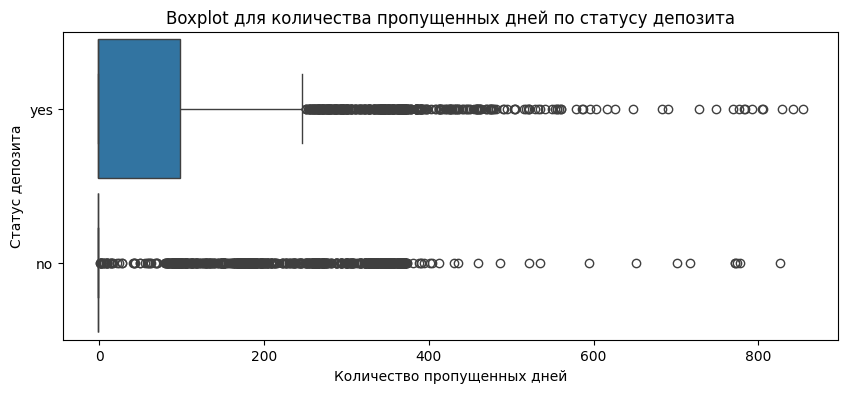

In [27]:
# строим график для количество пропущенных дней
fig = plt.figure(figsize=(10, 4))
boxplot = sns.boxplot(data=df_new, x='pdays', y='deposit', orient='h', width=0.9)
boxplot.set_title('Boxplot для количества пропущенных дней по статусу депозита', fontsize=12)
boxplot.set_xlabel('Количество пропущенных дней')
boxplot.set_ylabel('Статус депозита');

**Вывод:** четкой заивисимости на графике не наблюдается.

### Задания 4 и 5

In [28]:
df_new.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


**Выводы:**
- *сфера*: 11 уникальных значений, около 25% - менеджмент, скорее всего будет оказывать влияние на целевой признак, исходя из логики, необходимо проверить на гипотезах.;
- *семейный статус*: странно, что 3 значения, скорее всего одно из значений будет относиться к замежум/женат или не замуем/не женат, необходимо проверить. Чуть больше 50% - женат/замежем. Скорее всего так же будет оказывать влияние на целевой показатель, необходимо проверить на гипотезах.;
- *образование*: 3 уникальных значения, более 50% - secondary. Скорее всего так же будет оказывать влияние на целевой показатель, необходимо проверить на гипотезах;
- *наличие просрочки*: практически 99% - не имеют просрочки. Данный показатель будет неиформативен и не влияет на целевой показатель, данный показатель необходимо будет исключить;
- *наличие ипотеки*: практически 50/50 соотношение значений. Необходимо проверить связь между признаком и целевой переменной;
- *наличие кредита*: у 87% клиентов - нет кредита наличными, это может оказать влияние на целевой показатель;
- *тип контакта*: 3 уникальных значения, 73% - звонки. Необходимо проверить связь между признаком и целевой переменной;
- *месяц контакта*: 12 значений, что логично. Около 26% - значение "май". Скорее всего так же будет оказывать влияние на целевой показатель, необходимо проверить на гипотезах;
- *результат прошлой маркетинговой кампании*: около 76% - пропуски, данный показатель необходимо будет исключить.

Визуализируем на графиках категориальные признаки.

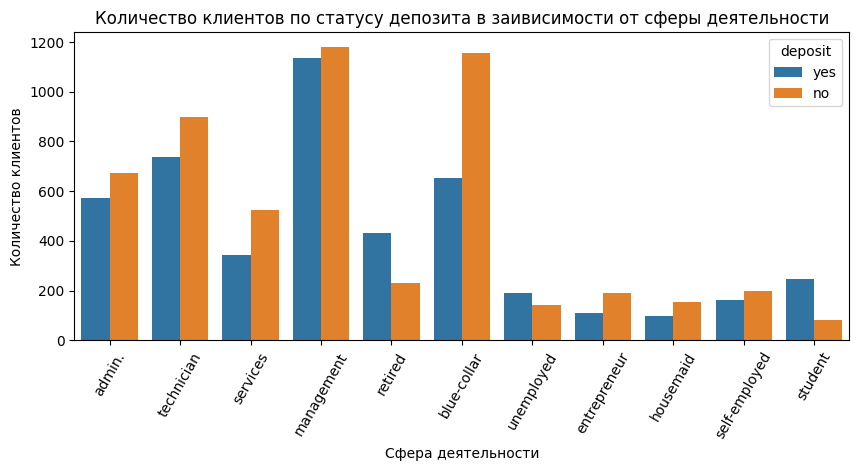

In [29]:
# посмотрим, как делятся сферы деятельности в долях по статусу депозита 
fig = plt.figure(figsize=(10, 4))
count_plot = sns.countplot(df_new, x='job', hue='deposit')
count_plot.xaxis.set_tick_params(rotation=60)
count_plot.set_title('Количество клиентов по статусу депозита в заивисимости от сферы деятельности')
count_plot.set_xlabel('Сфера деятельности')
count_plot.set_ylabel('Количество клиентов');

**Вывод:** по части сфер деятельности количество согласных на депозит преобладает над теми, кто против. Голубые воротнички - 2/3 клиентов отказались открывать депозит. Категории граждан с более низкими зарплатами: пенсионеры,студенты, безработные, домохозяйки и частные предприниматели - по этим категориям чаще встречают те, кто соглашается открыть депозит.

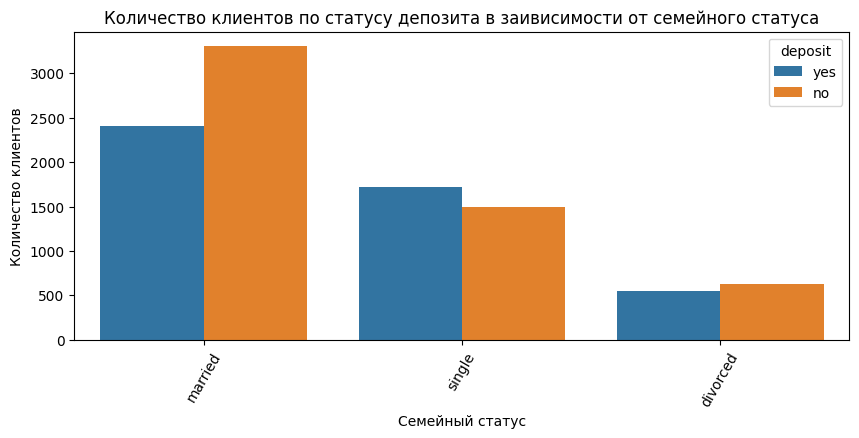

In [30]:
# посмотрим, как делятся клиенты по семейному статусу в долях по статусу депозита 
fig = plt.figure(figsize=(10, 4))
count_plot = sns.countplot(df_new, x='marital', hue='deposit')
count_plot.xaxis.set_tick_params(rotation=60)
count_plot.set_title('Количество клиентов по статусу депозита в заивисимости от семейного статуса')
count_plot.set_xlabel('Семейный статус')
count_plot.set_ylabel('Количество клиентов');

**Вывод:** во первых, клиенты со статусом "в разводе" нужно перенести в группу "одинокие". Во-вторых, видно, что сеймейные люди менее охотно открывают депозит.

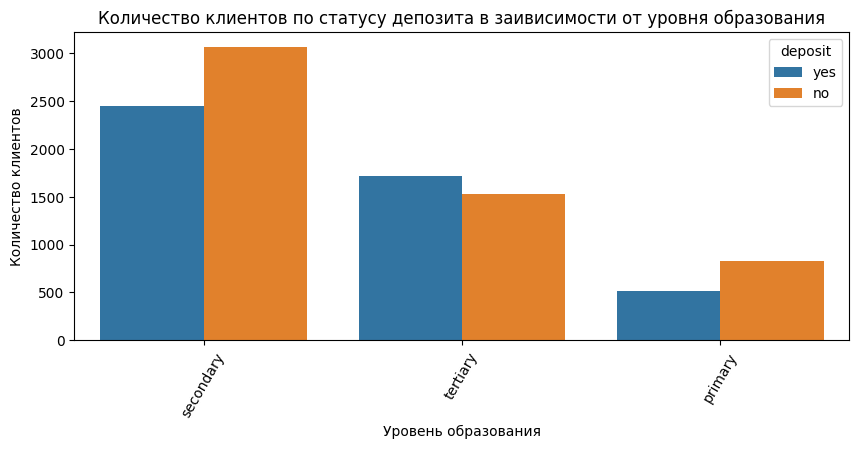

In [31]:
# посмотрим, как делятся клиенты по уровню образования в долях по статусу депозита 
fig = plt.figure(figsize=(10, 4))
count_plot = sns.countplot(df_new, x='education', hue='deposit')
count_plot.xaxis.set_tick_params(rotation=60)
count_plot.set_title('Количество клиентов по статусу депозита в заивисимости от уровня образования')
count_plot.set_xlabel('Уровень образования')
count_plot.set_ylabel('Количество клиентов');

**Вывод:** видно, что у категории клиентов с уровнем образования "secondary" чаще соглашаются на открытие депозита, так же у категории клиентов с уровнем образования "primary" доля клиентов, согласных на депозит - выше. Есть подозрение, что клиентов с более низким уровнем образования проще убедить в открытии депозита.

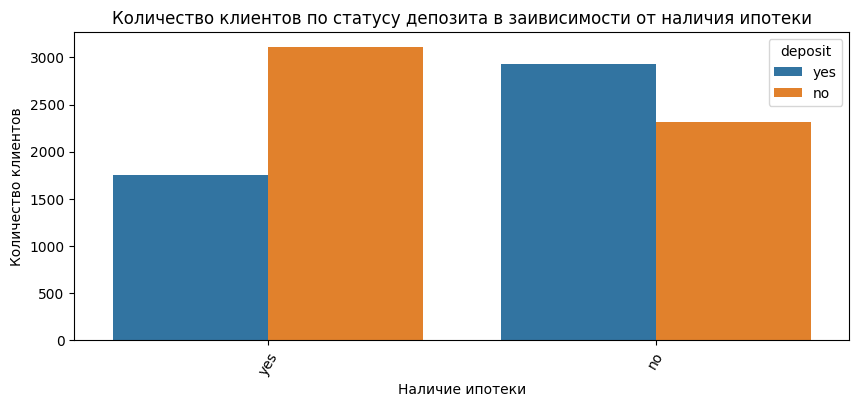

In [32]:
# посмотрим, как делятся клиенты с ипотекой в долях по статусу депозита 
fig = plt.figure(figsize=(10, 4))
count_plot = sns.countplot(df_new, x='housing', hue='deposit')
count_plot.xaxis.set_tick_params(rotation=60)
count_plot.set_title('Количество клиентов по статусу депозита в заивисимости от наличия ипотеки')
count_plot.set_xlabel('Наличие ипотеки')
count_plot.set_ylabel('Количество клиентов');

**Вывод:** на графике видно, что клиенты с ипотекой не стремсятся к открытию депозитов, чего не скажешь, про клиентов, у которых нет ипотеки.

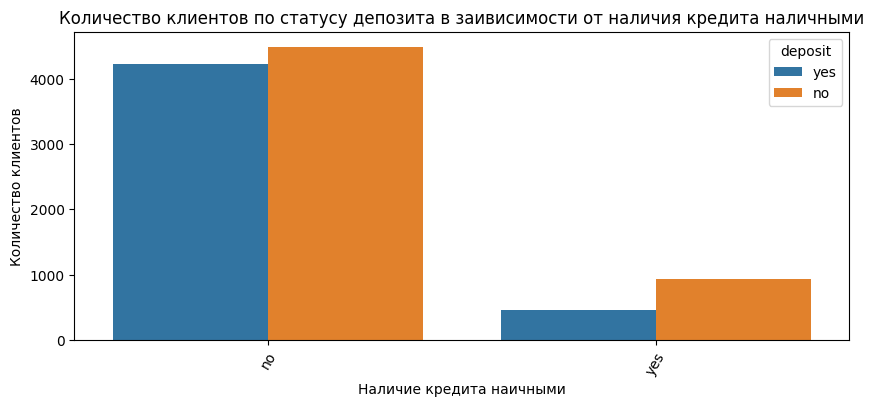

In [33]:
# посмотрим, как делятся клиенты с кредитами наличными в долях по статусу депозита 
fig = plt.figure(figsize=(10, 4))
count_plot = sns.countplot(df_new, x='loan', hue='deposit')
count_plot.xaxis.set_tick_params(rotation=60)
count_plot.set_title('Количество клиентов по статусу депозита в заивисимости от наличия кредита наличными')
count_plot.set_xlabel('Наличие кредита наичными')
count_plot.set_ylabel('Количество клиентов');

**Вывод:** на графике не наблюдается четкая взаимосвязь, видно, что клиенты без кредита прктически распределены 50/50. А клиенты с кредитами явно соглашаются меньше на открытие депозита, что логично.

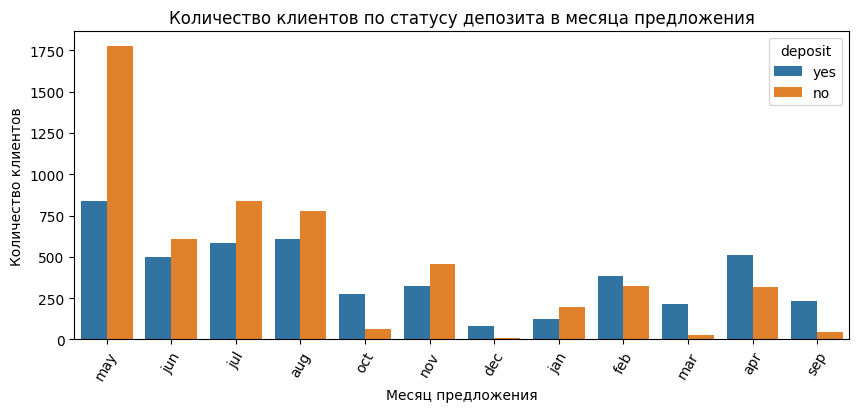

In [34]:
# посмотрим, как делятся месяцы предложения кампании в долях по статусу депозита 
fig = plt.figure(figsize=(10, 4))
count_plot = sns.countplot(df_new, x='month', hue='deposit')
count_plot.xaxis.set_tick_params(rotation=60)
count_plot.set_title('Количество клиентов по статусу депозита в месяца предложения')
count_plot.set_xlabel('Месяц предложения')
count_plot.set_ylabel('Количество клиентов');

**Вывод:** с мая по авнуст количество контактов наибольшее, однако в этот период клиенты не соглашаются на открытие вкладов, возможно в виду праздников и отпусков, когда люди тратят финансы на другие цели нежели сбережения.

### Задание 6

In [35]:
df_new.groupby(['poutcome', 'deposit'])['deposit'].count()

poutcome  deposit
failure   no          562
          yes         547
other     no          216
          yes         265
success   no           84
          yes         861
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

**Вывод:** положительных результатов сильно больше в текущей компании для клиентов, у которых статус прошлой кампании был 'success'.

### Задание 7

In [36]:
df[df['deposit'] == 'no'].groupby('month')['deposit'].count().sort_values(ascending=False)

month
may    1899
jul     887
aug     831
jun     676
nov     540
apr     346
feb     335
jan     202
oct      69
sep      50
mar      28
dec      10
Name: deposit, dtype: int64

**Вывод:** в мае было больше всего отказов.

### Задание 8

In [37]:
def age_group(x):
    y = ''
    if x < 30:
        y = '<30'
    elif x >= 30 and x < 40:
        y = '30-40'
    elif x >= 40 and x < 50:
        y = '40-50'
    elif x >= 50 and x < 60:
        y = '50-60'
    else:
        y = '60+'
    return y

In [38]:
df_new['age_group'] = df_new['age'].apply(age_group)
df_new['age_group'].unique()

array(['50-60', '40-50', '60+', '30-40', '<30'], dtype=object)

In [39]:
df_new.groupby(['age_group', 'deposit'])['deposit'].count()

age_group  deposit
30-40      no         2245
           yes        1716
40-50      no         1444
           yes         938
50-60      no          984
           yes         670
60+        no          157
           yes         496
<30        no          594
           yes         861
Name: deposit, dtype: int64

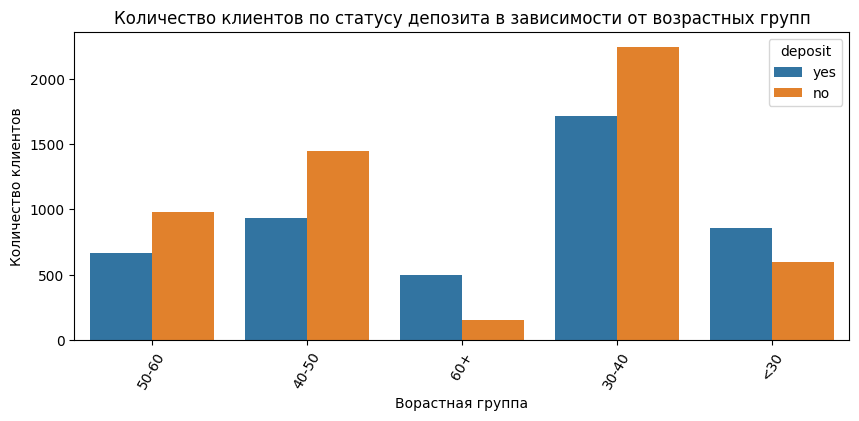

In [40]:
# посмотрим, как делятся месяцы предложения кампании в долях по статусу депозита 
fig = plt.figure(figsize=(10, 4))
count_plot = sns.countplot(df_new, x='age_group', hue='deposit')
count_plot.xaxis.set_tick_params(rotation=60)
count_plot.set_title('Количество клиентов по статусу депозита в зависимости от возрастных групп')
count_plot.set_xlabel('Ворастная группа')
count_plot.set_ylabel('Количество клиентов');

### Задания 9 и 10

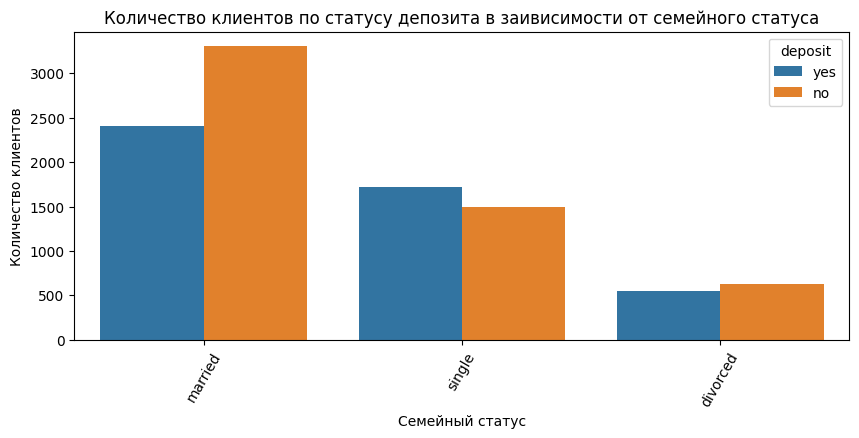

In [41]:
# посмотрим, как делятся клиенты по семейному статусу в долях по статусу депозита 
fig = plt.figure(figsize=(10, 4))
count_plot = sns.countplot(df_new, x='marital', hue='deposit')
count_plot.xaxis.set_tick_params(rotation=60)
count_plot.set_title('Количество клиентов по статусу депозита в заивисимости от семейного статуса')
count_plot.set_xlabel('Семейный статус')
count_plot.set_ylabel('Количество клиентов');

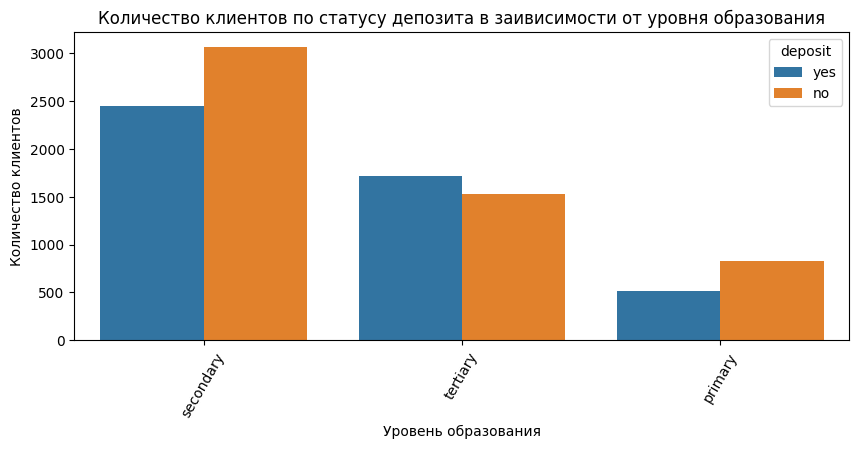

In [42]:
# посмотрим, как делятся клиенты по уровню образования в долях по статусу депозита 
fig = plt.figure(figsize=(10, 4))
count_plot = sns.countplot(df_new, x='education', hue='deposit')
count_plot.xaxis.set_tick_params(rotation=60)
count_plot.set_title('Количество клиентов по статусу депозита в заивисимости от уровня образования')
count_plot.set_xlabel('Уровень образования')
count_plot.set_ylabel('Количество клиентов');

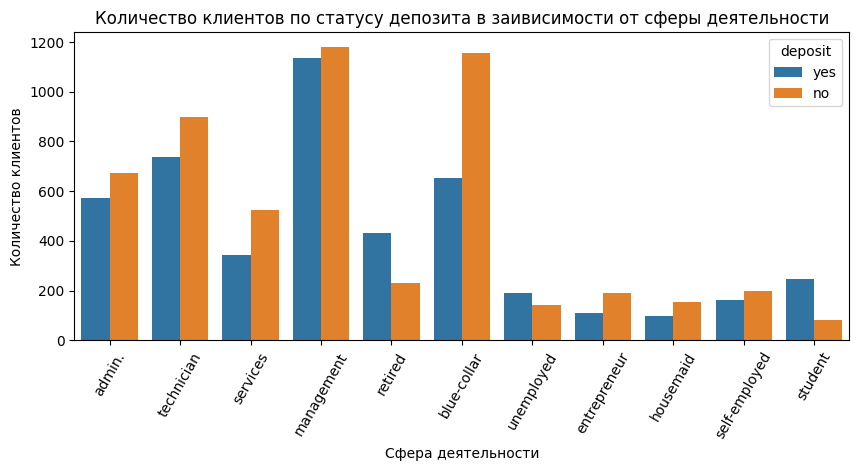

In [43]:
# посмотрим, как делятся сферы деятельности в долях по статусу депозита 
fig = plt.figure(figsize=(10, 4))
count_plot = sns.countplot(df_new, x='job', hue='deposit')
count_plot.xaxis.set_tick_params(rotation=60)
count_plot.set_title('Количество клиентов по статусу депозита в заивисимости от сферы деятельности')
count_plot.set_xlabel('Сфера деятельности')
count_plot.set_ylabel('Количество клиентов');

### Задание 11

In [44]:
df_new[df_new['deposit'] == 'yes'].pivot_table(
    values='deposit',
    index='education',
    columns='marital',
    aggfunc='count'
)

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


## Часть 3: преобразование данных

### Задание 1

In [45]:
le = LabelEncoder()
df_new['education'] = le.fit_transform(df_new['education'])

In [46]:
df_new['education'].sum()

11995

In [47]:
le.classes_

array(['primary', 'secondary', 'tertiary'], dtype=object)

In [48]:
le_age = LabelEncoder()
df_new['age_group_code'] = le_age.fit_transform(df_new['age_group'])

In [49]:
print(df_new['age_group_code'].unique())
print(le_age.classes_)

[2 1 3 0 4]
['30-40' '40-50' '50-60' '60+' '<30']


### Задания 2 и 3

In [50]:
df_new['deposit'] = df_new['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [51]:
df_new['deposit'].std().round(3)

0.499

In [52]:
df_new['default'] = df_new['default'].apply(lambda x: 1 if x == 'yes' else 0)
df_new['housing'] = df_new['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_new['loan'] = df_new['loan'].apply(lambda x: 1 if x == 'yes' else 0)

In [53]:
print(round(df_new['default'].mean() + df_new['housing'].mean() + df_new['loan'].mean(), 3))

0.635


### Задание 4

In [54]:
df_dummies = pd.get_dummies(df_new, columns = ['job', 'marital', 'contact', 'month', 'poutcome'])

In [55]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  object 
 13  age_group_code     10105 non-null  int32  
 14  job_admin.         10105 non-null  uint8  
 15  job_blue-collar    10105 non-null  uint8  
 16  job_entrepreneur   101

In [56]:
df_dummies = df_dummies.drop(['age', 'age_group'], axis=1)

### Задания 5 и 6

In [57]:
df_corr = df_dummies.corr()['deposit'].abs().sort_values(ascending=False)

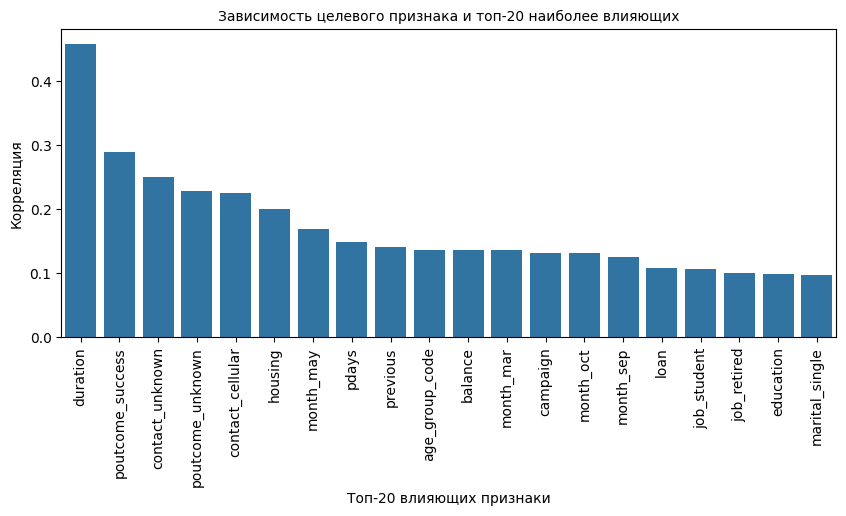

In [58]:
# построим график распределения признаков по силе влияния на целевой
fig = plt.figure(figsize=(10, 4))
bar = sns.barplot(df_corr[1:21])
bar.xaxis.set_tick_params(rotation=90)
bar.set_xlabel('Топ-20 влияющих признаки')
bar.set_ylabel('Корреляция')
bar.set_title('Зависимость целевого признака и топ-20 наиболее влияющих', size=10);

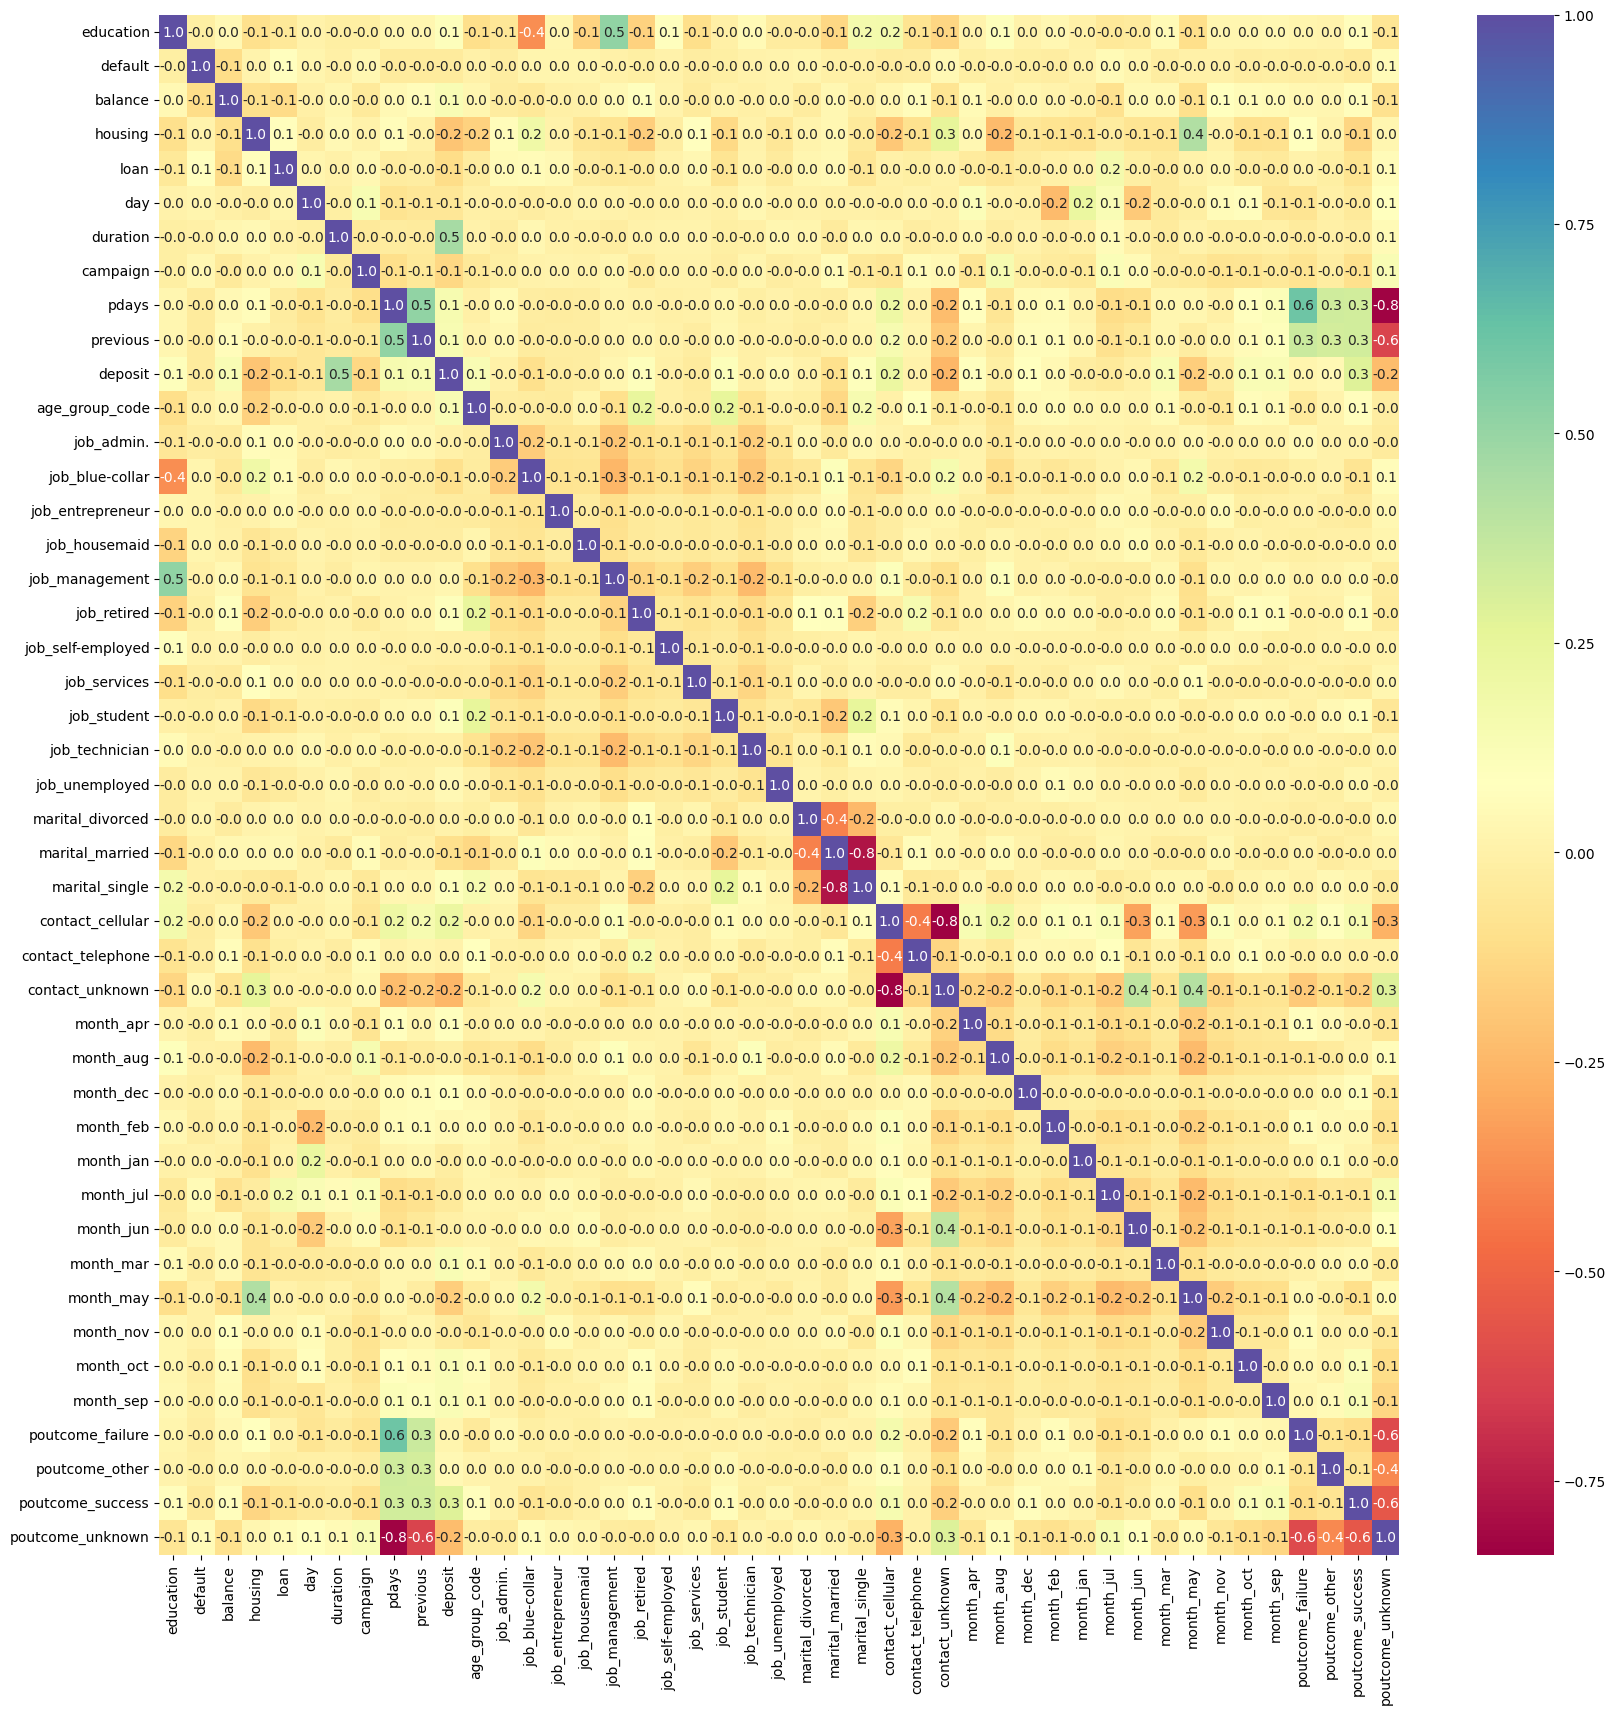

In [59]:
# построим тепловую карту матрицы корреляции
fig = plt.figure(figsize=(20, 20))
sns.heatmap(df_dummies.corr(), annot=True, fmt='.1f', cmap='Spectral');

### Задания 7 и 8

In [60]:
# сформируем тренировочный и тестовый наборы
X = df_dummies.drop(['deposit'], axis=1)
y = df_dummies['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [61]:
print('test size: {} and mean target: {}'.format(X_test.shape, y_test.mean().round(2)))

test size: (3335, 44) and mean target: 0.46


### Задание 9

In [62]:
# отберем 15 наиболее значимых признаков с помощью SelectKBest
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
list_select = list(selector.get_feature_names_out())
print(list_select)

['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_group_code', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


### Задание 10

In [63]:
X_train_new = X_train[list_select]
X_test_new = X_test[list_select]
X_test_new.head(5)

,balance,housing,duration,campaign,pdays,previous,age_group_code,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
3333,155.0,0,290,1,93,2,3,0,0,1,0,0,0,1,0
6048,512.0,0,70,1,-1,0,2,1,0,0,0,0,0,0,1
5675,1403.0,0,214,8,326,2,0,1,0,0,1,0,0,0,0
2564,1270.0,0,232,3,-1,0,0,1,0,0,0,0,0,0,1
8983,1074.0,1,523,2,-1,0,2,0,1,0,1,0,0,0,1


In [64]:
scaler = MinMaxScaler()
scaler.fit(X_train_new)
X_train_scaled = scaler.transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)
X_test_scaled[:, 0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [65]:
lg = linear_model.LogisticRegression(max_iter=1000, random_state=42, solver='sag')
lg.fit(X_train_scaled, y_train)
y_pred_lg = lg.predict(X_test_scaled)
print('Acc on test: {}'.format(round(metrics.accuracy_score(y_test, y_pred_lg), 4)))


Acc on test: 0.8048


### Задания 2,3,4

In [66]:
dt = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt.fit(X_train_scaled, y_train)
y_train_pred_dt = dt.predict(X_train_scaled)
y_test_pred_dt = dt.predict(X_test_scaled)
print('f1 on train: {}'.format(round(metrics.f1_score(y_train_pred_dt, y_train), 2)))
print('f1 on test: {}'.format(round(metrics.f1_score(y_test_pred_dt, y_test), 2)))
print('Acc on train: {}'.format(round(metrics.accuracy_score(y_train_pred_dt, y_train), 2)))
print('Acc on test: {}'.format(round(metrics.accuracy_score(y_test_pred_dt, y_test), 2)))

f1 on train: 1.0
f1 on test: 0.72
Acc on train: 1.0
Acc on test: 0.75


In [67]:
train_acc_list = []
test_acc_list = []
for i in range(2, 11, 1):
    dt = tree.DecisionTreeClassifier(max_depth=i, criterion = 'entropy', random_state = 42)
    dt.fit(X_train_scaled, y_train)
    y_train_pred_dt = dt.predict(X_train_scaled)
    y_test_pred_dt = dt.predict(X_test_scaled)
    train_acc_list.append(round(metrics.accuracy_score(y_train_pred_dt, y_train), 2))
    test_acc_list.append(round(metrics.accuracy_score(y_test_pred_dt, y_test), 2))
print(list(range(2, 11, 1)))
print(train_acc_list)
print(test_acc_list)

[2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.73, 0.78, 0.78, 0.8, 0.82, 0.84, 0.84, 0.85, 0.87]
[0.72, 0.77, 0.77, 0.79, 0.81, 0.82, 0.81, 0.81, 0.8]


### Задание 5

In [68]:
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
y_test_pred_gs = grid_search_tree.predict(X_test_scaled)

CPU times: total: 719 ms
Wall time: 5.42 s
f1 on test: 0.80
best params: {'max_depth': 7, 'min_samples_split': 2}


In [75]:
print('f1 on test: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred_gs)))
print('best params: {}'.format(grid_search_tree.best_params_))

f1 on test: 0.8015
best params: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [122]:

# построим модель случайного леса
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print('acc on test: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred_rf)))
print('recall on test: {:.2f}'.format(metrics.recall_score(y_test, y_pred_rf)))
print('f1 on test: {:.2f}'.format(metrics.f1_score(y_test, y_pred_rf)))

acc on test: 0.83
recall on test: 0.83
f1 on test: 0.82


### Задания 2 и 3

In [80]:
# построим модель градиентного бустинга
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, 
    n_estimators=300, 
    min_samples_leaf = 5,
    max_depth=5, 
    random_state=42 
)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
print('f1 on test: {:.2f}'.format(metrics.f1_score(y_test, y_pred_gb)))

f1 on test: 0.82


**Вывод:** модель градиентного бустинга не превзошла результат случайного леса

### Задание 4

In [82]:
estimators = [
    ('rf', rf),
    ('lg', lg),
    ('gb',  gb)
]

In [87]:
# построим объект класса стекинг
stack = ensemble.StackingClassifier(
    estimators=estimators, 
    final_estimator=linear_model.LogisticRegression(max_iter=1000, random_state=42)
)
stack.fit(X_train_scaled, y_train)
y_pred_reg = stack.predict(X_test_scaled)
print('precision on test: {:.2f}'.format(metrics.precision_score(y_test, y_pred_gb)))

precision on test: 0.80


### Задание 5

In [108]:
# создадим объкт SelectKBest для отбора наиболее важных признаков
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train, y_train)

SelectKBest(k=3)

In [106]:
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

**Вывод:** наиболее значимыми признаками, оказывающими наибольшее влияние, являются 'duration', 'contact_unknown', 'poutcome_success'

### Задания 6,7,8

In [113]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [114]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-04-18 11:13:02,371] A new study created in memory with name: RandomForestClassifier
[I 2024-04-18 11:13:03,454] Trial 0 finished with value: 0.8513174404015056 and parameters: {'n_estimators': 180, 'max_depth': 18, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8513174404015056.
[I 2024-04-18 11:13:04,706] Trial 1 finished with value: 0.8608981380065719 and parameters: {'n_estimators': 167, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8608981380065719.
[I 2024-04-18 11:13:05,659] Trial 2 finished with value: 0.8536127619643417 and parameters: {'n_estimators': 148, 'max_depth': 14, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8608981380065719.
[I 2024-04-18 11:13:06,302] Trial 3 finished with value: 0.8514572234409276 and parameters: {'n_estimators': 103, 'max_depth': 29, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8608981380065719.
[I 2024-04-18 11:13:07,337] Trial 4 finished with value: 0.8466257668711655 and parameters: {'n_

CPU times: total: 25.6 s
Wall time: 26.8 s


In [115]:
# выводим результаты на тестовой выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 199, 'max_depth': 20, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [120]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)
print('f1 on test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('acc on test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

f1 on test: 0.82
acc on test: 0.82


In [117]:
# построим график истории оптимизации гиперпараметров
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [118]:
# построим визуализации важности гиперпараметров модели
optuna.visualization.plot_param_importances(study, target_name="f1_score")